In [16]:
from typing import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image, ImageStat, ImageOps

from sot.bbox import BBox
from sot.utils import Size

plt.style.use('tableau-colorblind10')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
ImageT = Image.Image

def center_crop_and_resize(
        img: np.ndarray, bbox: BBox, target_size: Size,
        border: Optional[Union[int, Tuple[int, ...]]] = None,
        interpolation=cv.INTER_CUBIC) -> np.ndarray:
    assert img.ndim == 3, "expected three dimensional image"

    # Size as width and height
    bbox_corners = bbox.as_corners()
    img_size = (img.shape[1], img.shape[0])
    paddings = np.concatenate((-bbox_corners[:2], bbox_corners[2:] - img_size))
    max_padding = np.maximum(paddings, 0).max()

    if max_padding > 0:
        if border is None:
            border = tuple(int(c) for c in np.mean(img, axis=(0, 1)).round())

        img = cv.copyMakeBorder(
            img, max_padding, max_padding, max_padding, max_padding,
            borderType=cv.BORDER_CONSTANT, value=border)
        bbox_corners += max_padding

    patch = img[
            bbox_corners[1]:bbox_corners[3], bbox_corners[0]:bbox_corners[2]]
    patch = cv.resize(patch, dsize=target_size, interpolation=interpolation)

    return patch

def center_crop_and_resize_new(
        img: ImageT, bbox: BBox, target_size: Size,
        border: Optional[Union[int, Tuple[int, ...]]] = None,
        interpolation=Image.BICUBIC) -> np.ndarray:
    bbox_corners = bbox.as_corners()
    paddings = np.concatenate((-bbox_corners[:2], bbox_corners[2:] - img.size))
    max_padding = np.maximum(paddings, 0).max()

    if max_padding > 0:
        if border is None:
            border = tuple(int(round(c)) for c in ImageStat.Stat(img).mean)

        img = ImageOps.expand(img, border=max_padding, fill=border)
        bbox_corners += max_padding

    bbox_corners = tuple((bbox_corners).astype(int))
    patch = img.crop(bbox_corners)
    patch = patch.resize(target_size, interpolation)

    return patch

img_file_path = "../tmp_img.jpg"
img_cv = cv.imread(img_file_path, cv.IMREAD_COLOR)
img_pil = Image.open(img_file_path)

bbox = BBox(320, 30, 800, 800)
target_size = (255, 255)
cv_crop = center_crop_and_resize(img_cv, bbox, target_size)
pil_crop = center_crop_and_resize_new(img_pil, bbox, target_size)

In [14]:
cv.imshow("preview", cv_crop)
cv.waitKey(0)
cv.destroyAllWindows()

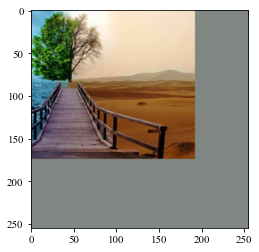

In [13]:
plt.imshow(np.asarray(pil_crop))

In [27]:
imgs = torch.stack([torch.rand((1, 3, 255, 255)) for _ in range(5)], dim=0)
imgs.shape

torch.Size([5, 1, 3, 255, 255])